In [4]:
from scipy.signal import filtfilt
from scipy.signal import butter,lfilter
from scipy.signal import freqs,freqz
import numpy as np
from scipy.fft import fft,ifft,fftfreq
import pandas as pd
import matplotlib.pyplot as plt 

from scipy import signal
%matplotlib inline
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import ipywidgets as widgets
from obspy.signal.trigger import recursive_sta_lta,carl_sta_trig,plot_trigger#,trigger_onset
from obspy.core.trace import Trace
from collections import deque 

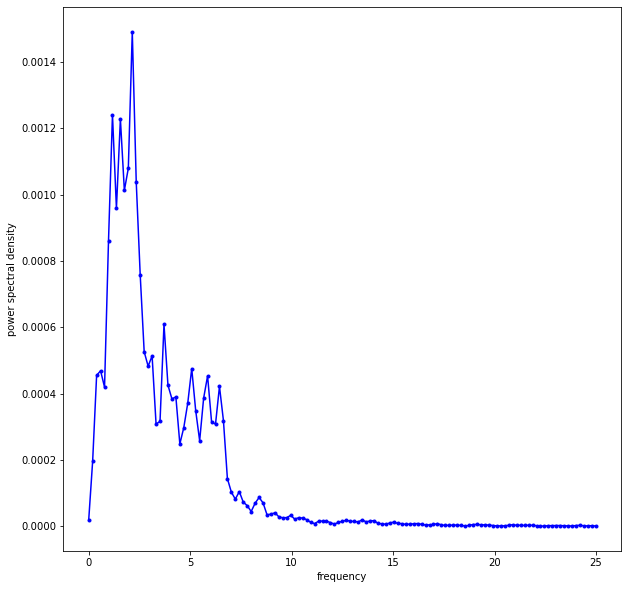

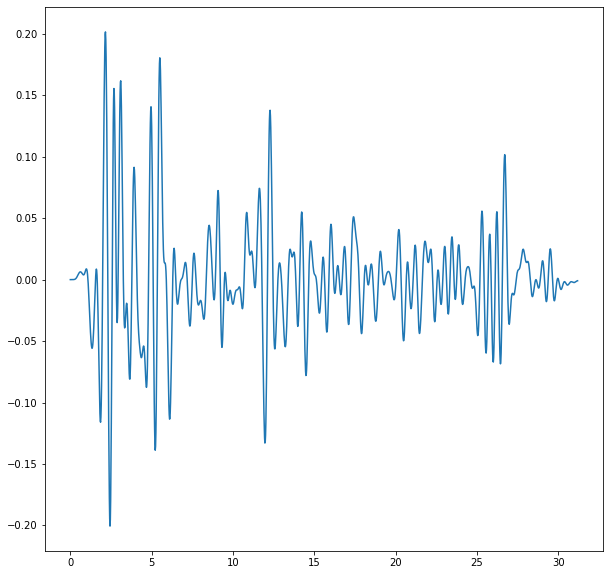

In [30]:
my_step=pd.read_csv('elcentro.csv')
X=my_step['Acceleration']
plt.figure(figsize=(10,10))
freq,psd=signal.welch(X,50)
plt.plot(freq,psd,'b.-')#plotting psd using welches method
plt.xlabel('frequency')
plt.ylabel('power spectral density')
b, a = butter(10, 0.1, btype='low', analog=False)
y = lfilter(b, a, X)    
plt.figure(figsize=(10,10))
plt.plot(my_step['Time'],y)

In [34]:
def trigger_onset(charfct, thres1, thres2, max_len=9e99, max_len_delete=False):    
    ind1 = np.where(charfct > thres1)[0]
    if len(ind1) == 0:
        return []
    ind2 = np.where(charfct > thres2)[0]
    #
    on = deque([ind1[0]])
    of = deque([-1])
    # determine the indices where charfct falls below off-threshold
    ind2_ = np.empty_like(ind2, dtype=bool)
    ind2_[:-1] = np.diff(ind2) > 10
    # last occurence is missed by the diff, add it manually
    ind2_[-1] = True
    of.extend(ind2[ind2_].tolist())
    on.extend(ind1[np.where(np.diff(ind1) > 1)[0] + 1].tolist())
    # include last pick if trigger is on or drop it
    if max_len_delete:
        # drop it
        of.extend([1e99])
        on.extend([on[-1]])
    else:
        # include it
        of.extend([ind2[-1]])
    #
    pick = []
    while on[-1] > of[0]:
        while on[0] <= of[0]:
             on.popleft()
        while of[0] < on[0]:
             of.popleft()
        if of[0] - on[0] > max_len:
            if max_len_delete:
                on.popleft()
                continue
            of.appendleft(on[0] + max_len)
        pick.append([on[0], of[0]])
    return np.array(pick, dtype=np.int64)

In [27]:
@widgets.interact(sta_time=(0.01,10,0.01),lta_time=(5,120,1),thr_on=(1,20,0.1),thr_off=(0.1,8,0.1))
def alpha_calc(sta_time,lta_time,thr_on,thr_off):
    alpha=np.zeros(len(y))
    sta=0.
    csta=1./sta_time
    clta=1./lta_time
    icsta=1-csta
    iclta=1-clta
    lta=1e-99
    for i in range(1,len(X)):
      a=(y[i]**2)
      sta=a*csta+icsta*sta
      lta=a*clta+iclta*lta
      if(i<lta_time):
            alpha[i]=0
      else:
             alpha[i]=sta/lta
    plt.figure(figsize=(10,10))
    plt.plot(alpha)
    cft=alpha
    trace=Trace(np.array(y))
    df = trace.stats.sampling_rate
    npts = trace.stats.npts
    t = np.arange(npts, dtype=np.float32) / df
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(211)
    ax1.plot(t*0.02,y , 'k')
    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.plot(t*0.02, cft, 'k')
    cft1=np.array(cft)
    on_off = np.array(trigger_onset(cft1, thr_on, thr_off))
    i, j = ax1.get_ylim()
    try:
        ax1.vlines(on_off[:, 0]*0.02 / df, i, j, color='r', lw=2,
                   label="Trigger On")
        ax1.vlines(on_off[:, 1]*0.02 / df, i, j, color='b', lw=2,
                   label="Trigger Off")
        ax1.legend()
    except IndexError:
        pass
    ax2.axhline(thr_on, color='red', lw=1, ls='--')
    ax2.axhline(thr_off, color='blue', lw=1, ls='--')
    ax2.set_xlabel("Time after %s [s]" % trace.stats.starttime.isoformat())
    fig.suptitle(trace.id)
    fig.canvas.draw()
    plt.show()

interactive(children=(FloatSlider(value=5.0, description='sta_time', max=10.0, min=0.01, step=0.01), IntSlider…

In [45]:
@widgets.interact(sta_time=(1,10,1),lta_time=(5,120,1))
def alpha_calc(sta_time,lta_time):
    sta1=np.cumsum(np.array(X)**2)
    lta1=sta1.copy()
    sta1[sta_time:]=sta1[sta_time:]-sta1[:-sta_time]
    sta1=sta1/sta_time
    lta1[lta_time:]=lta1[lta_time:]-lta1[:-lta_time]
    lta1=lta1/lta_time
    sta1[0:sta_time-1]=0
    dtiny=1e-99
    lta1[lta1<dtiny]=dtiny
    plt.figure(figsize=(10,10))
    plt.plot(sta1/lta1)
    plt.subplot()
    plt.figure(figsize=(9,9))
    plt.plot(lta1)
    plt.plot(sta1)
    cft=sta1/lta1
    on_off=(trigger_onset(sta1/lta1, 2.5, 0.8, max_len=9e99, max_len_delete=False))
    trace=Trace(np.array(X))
    df = trace.stats.sampling_rate
    npts = trace.stats.npts
    t = np.arange(npts, dtype=np.float32) / df
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(211)
    ax1.plot(t,trace.data, 'k')
    ax2 =fig.add_subplot(212, sharex=ax1)
    ax2.plot(t, cft, 'k')
    cft1=np.array(cft)
    on_off = np.array(trigger_onset(cft1, 2.6, 0.8))
    i,j = ax1.get_ylim()
    try:
        ax1.vlines(on_off[:, 0] / df, i, j, color='r', lw=2,
                   label="Trigger On")
        ax1.vlines(on_off[:, 1] / df, i, j, color='b', lw=2,
                   label="Trigger Off")
        ax1.legend()
    except IndexError:
        pass
    ax2.axhline(2.6, color='red', lw=1, ls='--')
    ax2.axhline(0.8, color='blue', lw=1, ls='--')
    ax2.set_xlabel("Time after %s [s]" % trace.stats.starttime.isoformat())
    fig.suptitle(trace.id)
    fig.canvas.draw()
    plt.show()


interactive(children=(IntSlider(value=5, description='sta_time', max=10, min=1), IntSlider(value=62, descripti…

array([1, 2, 2, 2, 2])